In [1]:
using Pkg
Pkg.activate(".")
using locaTE
using OptimalTransport
using NPZ
using StatsBase
using SparseArrays
using ProgressMeter
using Plots
using NearestNeighbors
using Graphs
using GraphSignals
using Printf
using Base.Threads
using LinearAlgebra
using MultivariateStats
using NNlib
using Discretizers
using EvalMetrics
FIG_DIR = "./"
PLT_CELL = 500
Nq = 500
epfrac = 0.1

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated`


0.1

In [2]:
# DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/Synthetic_1000/dyn-BFStrange/dyn-BFStrange-1000-1/"
DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/Synthetic_1000/dyn-SW/dyn-SW-1000-2/"
# DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/Curated/GSD/GSD-1000-2/"
# DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/Synthetic_1000/dyn-LI/dyn-LI-1000-2/"
# DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/Synthetic_1000/dyn-CY/dyn-CY-1000-2/"
cd(DATA_PATH)

In [3]:
using PyCall
ad = pyimport("anndata")
adata = ad.read_h5ad("anndata.h5ad") 
# extract time (true simulation time coordinate)
dpt_pseudotime = adata.obs[:dpt].to_numpy();

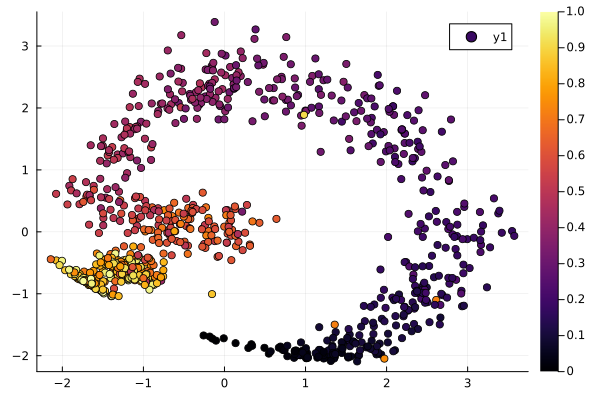

In [4]:
# compare to neighbourhood based on dpt_pseudotime
X = npzread("X.npy")
X_raw = npzread("X.npy")
X = relu.(X_raw .- 10^(-0.5));

X_pca = npzread("X_pca.npy")
scatter(X_pca[:, 1], X_pca[:, 2]; marker_z = dpt_pseudotime)

In [5]:
dpt = npzread("dpt.npy");

In [6]:
using Distances 
# manifold learning neighbourhoods (kNN)
C_mfd = npzread("C.npy")
R_mfd = quadreg(ones(size(X, 1)), ones(size(X, 1)), C_mfd, 2.5*mean(C_mfd));
# diffusion pseudotime neighbourhoods
C_dpt = pairwise(SqEuclidean(), dpt_pseudotime')
R_dpt = quadreg(ones(size(X, 1)), ones(size(X, 1)), C_dpt, 2.5*mean(C_dpt));

In [7]:
function apply_locate(P, Q, R, k; symm = false)
    R_sp = sparse(R)
    QT_sp = sparse((Q^k)')
    P_sp = sparse((P^k))
    TE = estimate_TE(X, 1:size(X, 2), 1:size(X, 2), P_sp, QT_sp, R_sp; showprogress = true, wclr = true);
    L = construct_normalized_laplacian(X_pca, 25);
    G = fitsp(TE, L; λ1 = 25, λ2 = 0.001, maxiter = 500);
    # transfer entropy with undirected kernel is not necessarily symmetric
    G = if symm locaTE.symm_row(G, size(X, 2)) else G end
    G_static = reshape(mean(G; dims = 1), size(X, 2), size(X, 2));
    # CDF normalization
    A = reshape(maximum(G; dims = 1), size(X, 2), size(X ,2))
    G_cdf = locaTE.apply_cdf_norm(G, A);
    # CDF normalization for static
    G_static_cdf = locaTE.cdf_norm(G_static, G_static .+ 1e-9);
    G_cdf, G_static_cdf
end

apply_locate (generic function with 1 method)

In [8]:
# static analysis first
G_pca, A_pca = apply_locate(R_mfd, to_backward_kernel(R_mfd), R_mfd, 1; symm = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
[ Info: ΔX = 4.144596858731065e-8, ΔZ = 1.6402630385530664e-5, ΔW = 2.0326264181646375e-5
[ Info: tr(X'LX) = 0.01827298612423893, 0.5|X-G|^2 = 0.5913425430044915, |X|1 = 95.8515693897219
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [9]:
G_dpt, A_dpt = apply_locate(R_dpt, to_backward_kernel(R_dpt), R_dpt, 1; symm = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
[ Info: ΔX = 4.664152093275306e-8, ΔZ = 9.14531718151576e-6, ΔW = 2.2735495001306727e-5
[ Info: tr(X'LX) = 0.003118306706180509, 0.5|X-G|^2 = 0.2777936960556987, |X|1 = 52.43562937162345


In [10]:
A_pidc = npzread("G_pidc.npy")

7×7 Matrix{Float64}:
 0.0       1.83153   0.691393  0.300603  0.656151  1.83308   0.507021
 1.83153   0.0       0.646764  1.18021   0.224457  1.62838   0.695699
 0.691393  0.646764  0.0       1.74923   0.768004  0.249316  0.234116
 0.300603  1.18021   1.74923   0.0       1.77822   0.159107  1.25653
 0.656151  0.224457  0.768004  1.77822   0.0       0.756745  1.87017
 1.83308   1.62838   0.249316  0.159107  0.756745  0.0       1.53372
 0.507021  0.695699  0.234116  1.25653   1.87017   1.53372   0.0

In [11]:
J = abs.(permutedims(npzread("J.npy"), [1, 3, 2]));
J_static = (mean(J; dims = 1)[1, :, :] .> 0.05)
J_static_symm = locaTE.symm(J_static);

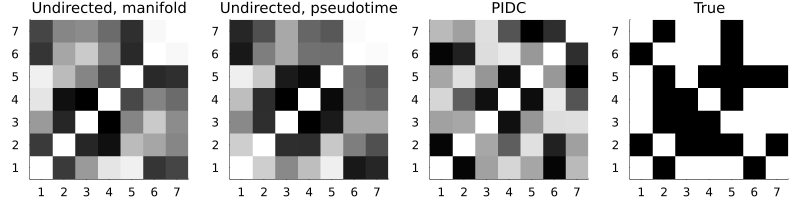

In [49]:
plt=plot(heatmap(A_pca; title = "Undirected, manifold", c = cgrad([:white,  :black])), 
    heatmap(A_dpt; title = "Undirected, pseudotime", c = cgrad([:white,  :black])), 
    heatmap(A_pidc; title = "PIDC", c = cgrad([:white,  :black])), 
    heatmap(J_static_symm; title = "True", c = cgrad([:white,  :black])); layout = (1, 4), size = (800, 200), colorbar = nothing, titlefontsize = 10)
savefig(joinpath(FIG_DIR, "switch_manifold_vs_dpt_undirected_heatmap.svg"))
plt

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


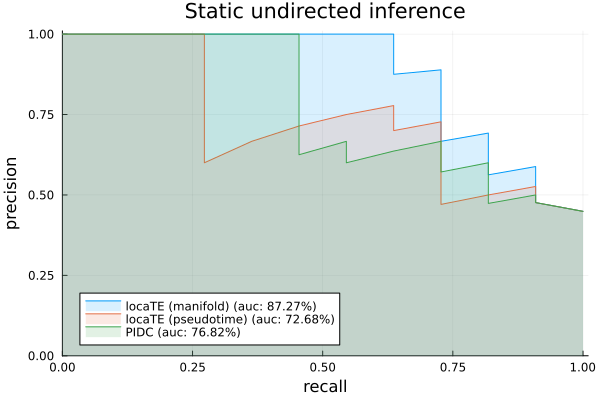

In [13]:
plt1=prplot(vec(J_static_symm), vec(A_pca); label = "locaTE (manifold)")
prplot!(vec(J_static_symm), vec(A_dpt); label = "locaTE (pseudotime)")
prplot!(vec(J_static_symm), vec(A_pidc); label = "PIDC")
plot!(plt1; title = "Static undirected inference")

In [25]:
G_pidc = repeat(vec(A_pidc), 1, size(X, 1))';

┌ Warning: The closest higher feasible true positive rate to some of the required values (0.9531772575250836, 0.9565217391304348, 0.959866220735786, 0.9632107023411371, 0.9665551839464883, 0.9698996655518395, 0.9732441471571907, 0.9765886287625418, 0.979933110367893, 0.9832775919732442, 0.9866220735785953, 0.9899665551839465, 0.9933110367892977, 0.9966555183946488) is 1.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:93
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: The closest higher feasible true positive rate to some of the required values (0.9531772575250836, 0.9565217391304348, 0.959866220735786, 0.9632107023411371, 0.9665551839464883, 0.9698996655518395, 0.9732441471571907, 0.9765886287625418, 0.979933110367893, 0.9832775919732442, 0.9866220735785953, 0.9899665551839465, 0.9933110367892977, 0.9966555183946488) is 1.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:93
┌ Warning

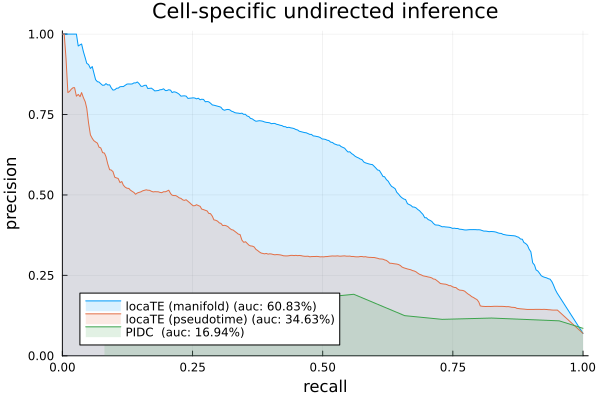

In [26]:
_J = locaTE.symm_row(reshape(abs.(J), :, size(X, 2) * size(X, 2)), size(X, 2))
plt2 = prplot(
    vec(R_mfd * _J) .> 0.5,
    vec(G_pca);
    label = "locaTE (manifold)",
)
prplot!(
    vec(R_mfd * _J) .> 0.5,
    vec(G_dpt);
    label = "locaTE (pseudotime)",
)
prplot!(
    vec(R_mfd * _J) .> 0.5,
    vec(G_pidc);
    label = "PIDC ",
)
plot!(plt2, title = "Cell-specific undirected inference")

In [27]:
FIG_DIR="/home/stephenz/stephenz/locaTE-paper/examples/simulated"

"/home/stephenz/stephenz/locaTE-paper/examples/simulated"

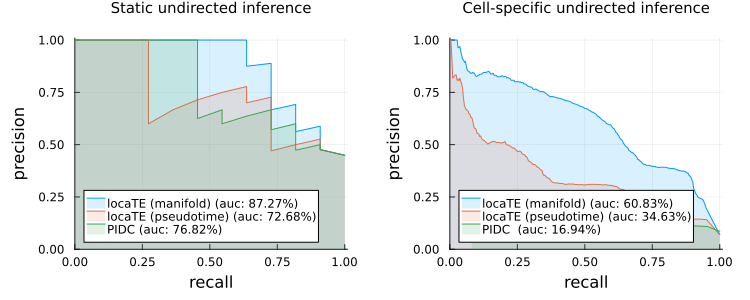

In [28]:
plt=plot(plt1, plt2; titlefontsize = 10, size = (750, 300), margin = 5*Plots.mm)
savefig(joinpath(FIG_DIR, "switch_manifold_vs_dpt_undirected.pdf"))
plt

In [29]:
# now try with velocity
P_velo_mfd = npzread("P_velo_dot.npy")
G_pca_velo, A_pca_velo = apply_locate(P_velo_mfd, locaTE.to_backward_kernel(P_velo_mfd), R_mfd, 3);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
[ Info: ΔX = 4.026460778947568e-8, ΔZ = 1.6653806352469325e-6, ΔW = 2.049148261901168e-5
[ Info: tr(X'LX) = 0.17191822047077757, 0.5|X-G|^2 = 1.395513869525356, |X|1 = 313.49668941834284


In [30]:
P_velo_dpt = npzread("P_velo_dot_dpt_knn.npy")
G_dpt_velo, A_dpt_velo = apply_locate(P_velo_dpt, locaTE.to_backward_kernel(P_velo_dpt), R_dpt, 3);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
[ Info: ΔX = 4.3262908736176444e-8, ΔZ = 8.364552845877005e-6, ΔW = 2.2108593128882664e-5
[ Info: tr(X'LX) = 0.03947543242466798, 0.5|X-G|^2 = 0.9422916577674103, |X|1 = 213.48777533718192


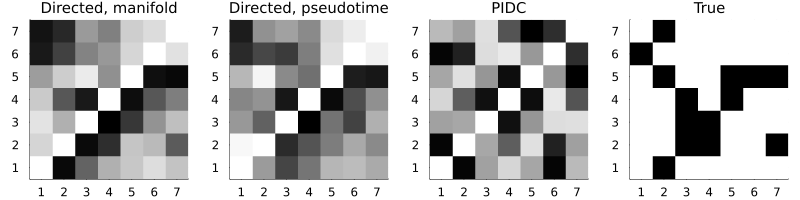

In [50]:
plt=plot(heatmap(A_pca_velo; title = "Directed, manifold", c = cgrad([:white,  :black])), 
    heatmap(A_dpt_velo; title = "Directed, pseudotime", c = cgrad([:white,  :black])), 
    heatmap(A_pidc; title = "PIDC", c = cgrad([:white,  :black])), 
    heatmap(J_static; title = "True", c = cgrad([:white,  :black])); layout = (1, 4), size = (800, 200), colorbar = nothing, titlefontsize = 10)
savefig(joinpath(FIG_DIR, "switch_manifold_vs_dpt_directed_heatmap.svg"))
plt

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


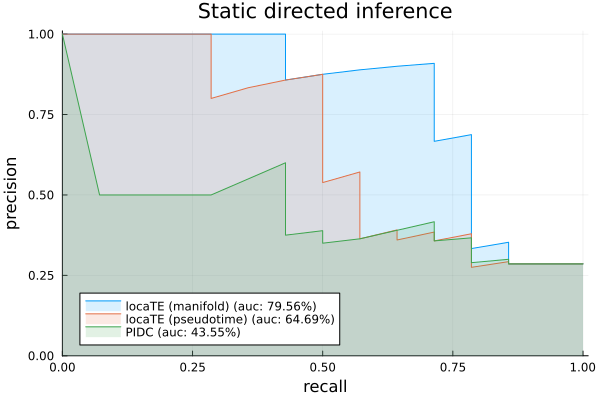

In [32]:
plt1=prplot(vec(J_static), vec(A_pca_velo); label = "locaTE (manifold)")
prplot!(vec(J_static), vec(A_dpt_velo); label = "locaTE (pseudotime)")
prplot!(vec(J_static), vec(A_pidc); label = "PIDC")
plot!(plt1; title = "Static directed inference")

┌ Warning: The closest higher feasible true positive rate to some of the required values (0.959866220735786, 0.9632107023411371, 0.9665551839464883, 0.9698996655518395, 0.9732441471571907, 0.9765886287625418, 0.979933110367893, 0.9832775919732442, 0.9866220735785953, 0.9899665551839465, 0.9933110367892977, 0.9966555183946488) is 1.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:93
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: The closest higher feasible true positive rate to some of the required values (0.9565217391304348, 0.959866220735786, 0.9632107023411371, 0.9665551839464883, 0.9698996655518395, 0.9732441471571907, 0.9765886287625418, 0.979933110367893, 0.9832775919732442, 0.9866220735785953, 0.9899665551839465, 0.9933110367892977, 0.9966555183946488) is 1.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONI

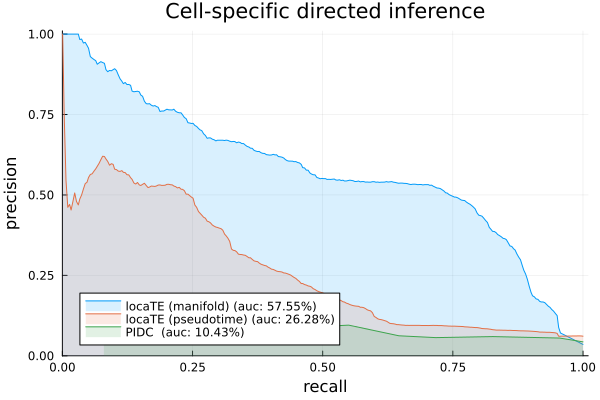

In [33]:
_J = reshape(abs.(J), :, size(X, 2) * size(X, 2))
plt2 = prplot(
    vec(R_mfd * _J) .> 0.5,
    vec(G_pca_velo);
    label = "locaTE (manifold)",
)
prplot!(
    vec(R_mfd * _J) .> 0.5,
    vec(G_dpt_velo);
    label = "locaTE (pseudotime)",
)
prplot!(
    vec(R_mfd * _J) .> 0.5,
    vec(G_pidc);
    label = "PIDC ",
)
plot!(plt2, title = "Cell-specific directed inference")

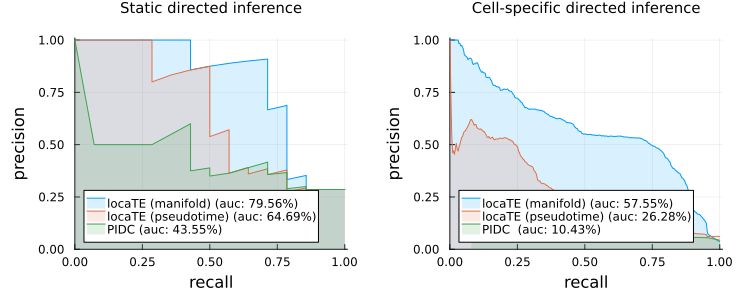

In [34]:
plt=plot(plt1, plt2; titlefontsize = 10, size = (750, 300), margin = 5*Plots.mm)
savefig(joinpath(FIG_DIR, "switch_manifold_vs_dpt_directed.pdf"))
plt

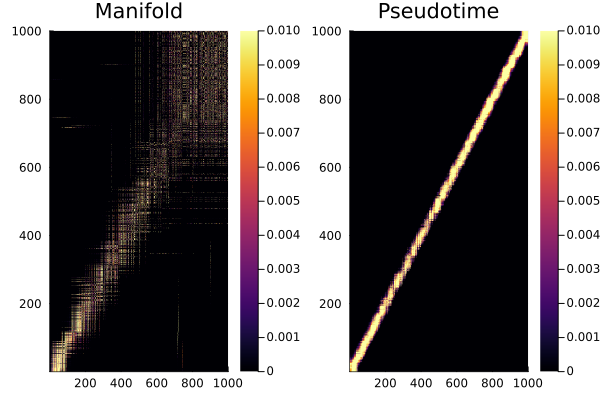

In [35]:
plot(heatmap((P_velo_mfd^3)[sortperm(dpt), :][:, sortperm(dpt)]; clim = (0, 0.01), title = "Manifold"), 
    heatmap((P_velo_dpt^3)[sortperm(dpt), :][:, sortperm(dpt)]; clim = (0, 0.01), title = "Pseudotime"))